### Hackathon demo:

This notebook demonstrates a **two-stage retrieval pipeline**:

1) **Image retrieval** (image embeddings + VLM caption embeddings)
   - Input: a query micrograph image
   - Retrieve: top‑K visually similar micrographs (using cosine similarity of image embeddings and caption word embeddings)
   - Output: top‑K images + similarity scores + paper IDs

2) **Textual RAG over source papers** (text embeddings)
   - Input: a user question (e.g., “Based on this image, describe potential synthesis details of this material”)
   - Select: the papers corresponding to the retrieved images
   - Chunk + embed: *only those papers* (cached on disk)
   - Retrieve: the most relevant text chunks by cosine similarity
   - Generate: a grounded answer with citations to the retrieved paper chunks


In [1]:
from pathlib import Path

# --- Config ---
# Notebook-friendly project root: assumes this notebook lives in the repo root.
PROJECT_ROOT = Path().resolve()
INDEX_DIR = PROJECT_ROOT / 'rag_index'
QUERY_INPUT_FILENAME = 'input6.png'   # one of: input1.png ... input6.png
TOP_K = 10
ALPHA = 0.8  # 1.0=image-only; <1.0 mixes in caption similarity if text embeddings exist
ONLY_MICROGRAPHS = True

RAG_QUERY_PY = PROJECT_ROOT / 'rag_query.py'

print('PROJECT_ROOT:', PROJECT_ROOT)
print('INDEX_DIR:', INDEX_DIR)
print('RAG_QUERY_PY exists:', RAG_QUERY_PY.exists())


PROJECT_ROOT: /Users/iamthomaspruyn/Documents/PhD/Projects/VLRIMM/VLRIMM
INDEX_DIR: /Users/iamthomaspruyn/Documents/PhD/Projects/VLRIMM/VLRIMM/rag_index
RAG_QUERY_PY exists: True


In [2]:
import json
import subprocess
import sys
import warnings

# Clean demo output: suppress numpy RuntimeWarnings that can appear if any embeddings contain NaNs/Infs.
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Build command (use the current interpreter)
cmd = [
    sys.executable,
    str(RAG_QUERY_PY),
    '--index-dir', str(INDEX_DIR),
    '--input-filename', QUERY_INPUT_FILENAME,
    '--top-k', str(TOP_K),
    '--alpha', str(ALPHA),
]
if not ONLY_MICROGRAPHS:
    cmd.append('--include-non-micrographs')

print('Running:', ' '.join(cmd))

proc = subprocess.run(cmd, capture_output=True, text=True)
stdout = (proc.stdout or '').strip()
stderr = (proc.stderr or '').strip()

print('returncode:', proc.returncode)
if stderr:
    print('--- stderr ---')
    print(stderr)

if proc.returncode != 0:
    raise RuntimeError(stdout or stderr or f'rag_query failed with code {proc.returncode}')

result = json.loads(stdout)
result


Running: /opt/miniconda3/envs/VLRIM/bin/python /Users/iamthomaspruyn/Documents/PhD/Projects/VLRIMM/VLRIMM/rag_query.py --index-dir /Users/iamthomaspruyn/Documents/PhD/Projects/VLRIMM/VLRIMM/rag_index --input-filename input6.png --top-k 10 --alpha 0.8
returncode: 0
--- stderr ---
/Users/iamthomaspruyn/Documents/PhD/Projects/VLRIMM/VLRIMM/rag_query.py:127: RuntimeWarning: divide by zero encountered in matmul
  sim_img = lit_img_embs @ q_img
/Users/iamthomaspruyn/Documents/PhD/Projects/VLRIMM/VLRIMM/rag_query.py:127: RuntimeWarning: overflow encountered in matmul
  sim_img = lit_img_embs @ q_img
/Users/iamthomaspruyn/Documents/PhD/Projects/VLRIMM/VLRIMM/rag_query.py:127: RuntimeWarning: invalid value encountered in matmul
  sim_img = lit_img_embs @ q_img
/Users/iamthomaspruyn/Documents/PhD/Projects/VLRIMM/VLRIMM/rag_query.py:136: RuntimeWarning: divide by zero encountered in matmul
  sim_txt = lit_txt @ q_txt
/Users/iamthomaspruyn/Documents/PhD/Projects/VLRIMM/VLRIMM/rag_query.py:136: Run

{'input_filename': 'input6.png',
 'top_k': 10,
 'alpha': 0.8,
 'results': [{'rank': 1,
   'score': 0.5954455137252808,
   'relpath': '1-s2.0-S0257897225008825-main/images_processed/picture_p8_14_row3_col1.png',
   'corpus_relpath': 'Literature/1-s2.0-S0257897225008825-main/images_processed/picture_p8_14_row3_col1.png',
   'corpus_abspath': '/Users/iamthomaspruyn/Documents/PhD/Projects/VLRIMM/VLRIMM/docling_output/1-s2.0-S0257897225008825-main/images_processed/picture_p8_14_row3_col1.png',
   'paper': '1-s2.0-S0257897225008825-main',
   'caption': 'The image shows a collection of irregularly shaped particles distributed across the field of view. The particles appear to have a rough surface texture and vary in size, with some agglomeration visible. The morphology suggests a granular structure with no apparent porosity or cracks. A scale bar indicating 100 µm is present in the image.',
   'archived_to': None},
  {'rank': 2,
   'score': 0.5881745219230652,
   'relpath': '1-s2.0-S0257897224

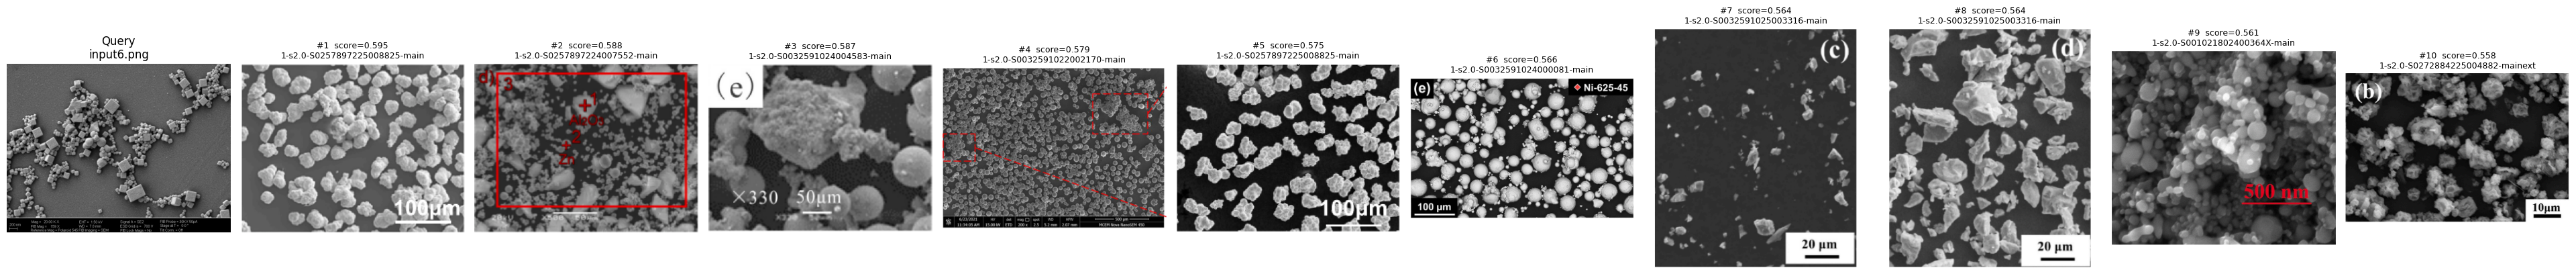


# 1 score=0.595
Literature/1-s2.0-S0257897225008825-main/images_processed/picture_p8_14_row3_col1.png
The image shows a collection of irregularly shaped particles distributed across the field of view. The particles appear to have a rough surface texture and vary in size, with some agglomeration visible. The morphology suggests a granular structure with no apparent porosity or cracks. A scale bar indicating 100 µm is present in the image.

# 2 score=0.588
Literature/1-s2.0-S0257897224007552-main/images_processed/picture_p4_4_row2_col1.png
The image shows a microstructure with irregularly shaped particles distributed across the field. There are larger particles surrounded by a matrix of smaller, more uniformly sized particles. The morphology of the larger particles appears angular, while the smaller particles are more rounded. A scale bar is present in the image, providing a reference for size comparison.

# 3 score=0.587
Literature/1-s2.0-S0032591024004583-main/images_processed/picture

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

# Helper to load image paths from result JSON

def _to_path(p: str) -> Path:
    pp = Path(p)
    return pp if pp.is_absolute() else (PROJECT_ROOT / pp)

query_path = _to_path(result['input_filename'])
# Prefer corpus paths if present in the input meta (rag_query output doesn't include it for query)
# We'll derive it from RAG_Corpus/Inputs
query_path = PROJECT_ROOT / 'RAG_Corpus' / 'Inputs' / result['input_filename']

rows = result['results']
paths = [Path(r['corpus_abspath']) for r in rows if r.get('corpus_abspath')]

# Plot: query + top-k
n = 1 + len(paths)
fig, axes = plt.subplots(1, n, figsize=(3.5 * n, 4))
if n == 1:
    axes = [axes]

# Query
axes[0].imshow(Image.open(query_path))
axes[0].set_title(f"Query\n{result['input_filename']}")
axes[0].axis('off')

# Results
for i, (ax, r) in enumerate(zip(axes[1:], rows), start=1):
    p = Path(r['corpus_abspath'])
    ax.imshow(Image.open(p))
    title = f"#{r['rank']}  score={r['score']:.3f}\n{r.get('paper','') or ''}"
    ax.set_title(title, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Print captions
for r in rows:
    print(f"\n# {r['rank']} score={r['score']:.3f}")
    print(r.get('corpus_relpath') or r.get('corpus_abspath'))
    cap = (r.get('caption') or '').strip()
    print(cap[:500] + ('…' if len(cap) > 500 else ''))


This section answers a **free-form user question** by searching only the papers corresponding to the top‑K retrieved images.

**What happens**
- Collect the unique **paper IDs** from the image retrieval results
- Load paper text from `RAG_Corpus/Literature/<paper>/<paper>.txt` (fallback: `text.txt`)
- Chunk the selected papers and embed chunks (cached to `rag_text_cache/`)
- Embed the user question and retrieve the most relevant chunks
- Generate a final answer with **inline citations** to the retrieved chunks



In [4]:
# --- Textual RAG config ---
RAG_ANSWER_PY = PROJECT_ROOT / 'rag_answer.py'
QUESTION = "Based on this image, describe potential synthesis details of this material."
TOP_K_IMAGES_FOR_TEXT = 10
TOP_N_CHUNKS = 12

# Controls how the image stage blends visual similarity and caption similarity.
# Use 1.0 for image-only, or e.g. 0.7 for hybrid (requires text embeddings to exist).
ALPHA_FOR_IMAGE_STAGE = ALPHA

print('RAG_ANSWER_PY exists:', RAG_ANSWER_PY.exists())
print('QUESTION:', QUESTION)


RAG_ANSWER_PY exists: True
QUESTION: Based on this image, describe potential synthesis details of this material.


In [5]:
import os
import sys

# `rag_answer.py` calls OpenAI for chunk embeddings and answer generation.
# Ensure the key is set in the environment where the notebook kernel is running.
if not os.environ.get('OPENAI_API_KEY'):
    raise RuntimeError("OPENAI_API_KEY is not set in this notebook kernel. Set it before running this cell.")

cmd = [
    sys.executable,
    str(RAG_ANSWER_PY),
    '--index-dir', str(INDEX_DIR),
    '--corpus-root', str(PROJECT_ROOT / 'RAG_Corpus'),
    '--input-filename', QUERY_INPUT_FILENAME,
    '--question', QUESTION,
    '--top-k-images', str(TOP_K_IMAGES_FOR_TEXT),
    '--top-n-chunks', str(TOP_N_CHUNKS),
    '--alpha', str(ALPHA_FOR_IMAGE_STAGE),
]

print('Running:', ' '.join(cmd))
proc = subprocess.run(cmd, capture_output=True, text=True)
stdout = (proc.stdout or '').strip()
stderr = (proc.stderr or '').strip()

print('returncode:', proc.returncode)
if stderr:
    print('--- stderr ---')
    print(stderr)

if proc.returncode != 0:
    raise RuntimeError(stdout or stderr or f'rag_answer failed with code {proc.returncode}')

answer_result = json.loads(stdout)
answer_result.keys()


Running: /opt/miniconda3/envs/VLRIM/bin/python /Users/iamthomaspruyn/Documents/PhD/Projects/VLRIMM/VLRIMM/rag_answer.py --index-dir /Users/iamthomaspruyn/Documents/PhD/Projects/VLRIMM/VLRIMM/rag_index --corpus-root /Users/iamthomaspruyn/Documents/PhD/Projects/VLRIMM/VLRIMM/RAG_Corpus --input-filename input6.png --question Based on this image, describe potential synthesis details of this material. --top-k-images 10 --top-n-chunks 12 --alpha 0.8
returncode: 0
--- stderr ---
/Users/iamthomaspruyn/Documents/PhD/Projects/VLRIMM/VLRIMM/rag_answer.py:96: RuntimeWarning: divide by zero encountered in matmul
  sim_img = lit_img @ q_img
/Users/iamthomaspruyn/Documents/PhD/Projects/VLRIMM/VLRIMM/rag_answer.py:96: RuntimeWarning: overflow encountered in matmul
  sim_img = lit_img @ q_img
/Users/iamthomaspruyn/Documents/PhD/Projects/VLRIMM/VLRIMM/rag_answer.py:96: RuntimeWarning: invalid value encountered in matmul
  sim_img = lit_img @ q_img
/Users/iamthomaspruyn/Documents/PhD/Projects/VLRIMM/VLRI

dict_keys(['input_filename', 'question', 'top_images', 'papers', 'retrieved_chunks', 'answer'])

In [6]:
from IPython.display import Markdown, display

# Show final answer
answer_text = (answer_result.get('answer') or '').strip()
display(Markdown('## Answer'))
display(Markdown(answer_text if answer_text else '_No answer returned._'))

# Show which papers were used
papers = answer_result.get('papers') or []
display(Markdown('## Retrieved papers'))
display(Markdown('\n'.join([f"- `{p}`" for p in papers]) or '_None_'))

# Show retrieved evidence chunks (grouped by paper)
chunks = answer_result.get('retrieved_chunks') or []
display(Markdown('## Retrieved evidence chunks'))

by_paper = {}
for c in chunks:
    by_paper.setdefault(c.get('paper','(unknown)'), []).append(c)

for p, cs in by_paper.items():
    display(Markdown(f"### `{p}`"))
    for c in cs:
        score = c.get('score')
        idx = c.get('chunk_index')
        text = (c.get('text') or '').strip()
        header = f"**chunk {idx} | sim={score:.3f}**" if isinstance(score, (int, float)) else f"**chunk {idx}**"
        display(Markdown(header))
        display(Markdown('```\n' + text[:2000] + ('\n…' if len(text) > 2000 else '') + '\n```'))


## Answer

Based on the image description and the provided evidence snippets, the material synthesis likely involves a process that can produce both cubic and spherical particles, potentially through powder atomization or spray conversion techniques.

1. **Powder Atomization**: The presence of cubic and spherical particles could suggest a powder atomization process. For instance, titanium powders can exhibit different morphologies depending on the atomization conditions, and the presence of voids or hollow particles can occur during this process [1-s2.0-S0032591025003316-main].

2. **Spray Conversion**: Another possibility is spray conversion, where precursor solutions are atomized to form fine droplets that solidify into spherical particles. This process can be influenced by factors such as temperature and the presence of additives like Cr, which can refine particle size and prevent agglomeration [1-s2.0-S0272884225004882-mainext].

3. **Key Parameters**:
   - **Temperature**: Processes like sintering or calcination are mentioned at temperatures ranging from 300°C to 1400°C, depending on the material system and desired microstructure [1-s2.0-S0032591025003316-main], [1-s2.0-S0272884225004882-mainext].
   - **Atmosphere**: The presence of air or inert gases like N2 during processing can affect the oxidation state and phase composition [1-s2.0-S001021802400364X-main].
   - **Time**: Holding times during processes like sintering or reduction are typically around 60 minutes [1-s2.0-S0272884225004882-mainext].

4. **Uncertainty Notes**: Without specific details on the material composition or exact synthesis method, there is uncertainty in pinpointing the precise synthesis route. The presence of both cubic and spherical particles suggests a complex process that may involve multiple steps or varying conditions.

In conclusion, the synthesis likely involves atomization or spray conversion, with key parameters including high temperatures and controlled atmospheres. Further details would be needed to confirm the exact process.

## Retrieved papers

- `1-s2.0-S0257897225008825-main`
- `1-s2.0-S0257897224007552-main`
- `1-s2.0-S0032591024004583-main`
- `1-s2.0-S0032591022002170-main`
- `1-s2.0-S0032591024000081-main`
- `1-s2.0-S0032591025003316-main`
- `1-s2.0-S001021802400364X-main`
- `1-s2.0-S0272884225004882-mainext`

## Retrieved evidence chunks

### `1-s2.0-S0032591025003316-main`

**chunk 26 | sim=0.586**

```
## 3.4. Microstructure evolution and mechanical properties

the presence of voids in the central region of the initial Ti powder, indicating the possible existence of hollow particles generated during the powder atomization process. However, the core of the particles in S2 and S4, which employ a finer titanium powder, exhibit minimal or no observable pores.

Fig. 6 displays the microstructure of S1, S2, and S4 at a sintering temperature of 1300 ◦ C. A conspicuous characteristic is the emergence of an α 2 + γ lamellar structure at this temperature. The lamellar domains are present as small islands in the matrix, enclosed by a dark γ -TiAl phases. Simultaneously, adjacent lamellar zones in the vicinity continue to expand and make contact with one another, as depicted in Fig. 5(d). By comparing the Ti-rich particle cores in Fig. 5, it can be inferred that the lamellar grains are produced within the initial Ti powder area. Fig. 6 (b) clearly illustrates that when the size of the Ti powder particles is large, the Ti-rich core, which has not undergone complete uniform diffusion, is visible at this temperature. It is surrounded by lamellae grains with different crystalline orientations. This result further substantiates the progressive growth of the lamellar into the Ti-rich core.
```

**chunk 27 | sim=0.575**

```
## 3.4. Microstructure evolution and mechanical properties

owder particles is large, the Ti-rich core, which has not undergone complete uniform diffusion, is visible at this temperature. It is surrounded by lamellae grains with different crystalline orientations. This result further substantiates the progressive growth of the lamellar into the Ti-rich core.

At a temperature of 1350 ◦ C, Fig. 7 displays the microstructure of the samples from three powder systems. The microstructure undergoes further changes compared to 1300 ◦ C. γ / α 2 lamellar colonies proliferate and dominate the majority of the area, while the remaining gamma colonies are present in limited quantities within lamellar colonies, resembling isolated islands and exhibiting characteristics similar to near-lamellar (NL) microstructure. The volume fraction and the grain size of lamellar colonies is about 83.4 % and 48 μ m measured by ImagePro and Nano Measurer. According to mid-section of the binary Ti -Al phase diagram [37], the α -transus temperature (T α ) for Ti -48Al is about 1380 ◦ C. Therefore, when sintering at 1400 ◦ C, over the α -transus line, the α grains in the matrix will grow rapidly due to the absence of the second phase pinning. Subsequently, the α → α + γ → α 2 + γ phase transition will occur during the cooling process, resulting in the formation of coarse full lamellar (FL) structure. Additionally, the volume fraction and the grain size of lamellar colonies is about 96.2 % and 63 μ m.

Based on the present observations, a microstructure evolution model is proposed, which illustrated in Fig. 8. Some researches demonstrate that the reaction of Ti with Al powder results in significant Kirkendall effect, which occurs when the diffusion coefficient of Al is higher than that of Ti, resulting in more Al atoms leaving Al particles than Ti atoms leaving Ti powders. Finally, Al particles shrink and form voids in their original place [38]. The formation of the TiAl3 phase occurs initially in t
…
```

**chunk 28 | sim=0.556**

```
## 3.4. Microstructure evolution and mechanical properties

urs initially in the reaction between Ti and Al particles due to its lower free energy in

(a)

(b)

Ti-rich core

S1

(b)

C. Zhang et al.

Ti concentrated

Fig. 5. Backscattered SEM microstructures (500 × ) of Ti -48Al alloys sintered at 1200 ◦ C for 180 min using powder S1 (a), S2 (b) and S4 (c).

Fig. 6. Backscattered SEM microstructures (500 × -a, c, d and 2000 × -b) of Ti -48Al alloys sintered at 1300 ◦ C for 180 min using powder S1 (a, b), S2 (c) and S4 (d).

comparison to other intermetallic compounds like TiAl and Ti3Al [39]. The porosity is primarily caused by volume variations resulting from the production of TiAl3 and the Kirkendall effect. By directly utilizing TiAl3 powder, the occurrence of this reaction is prevented and the density is enhanced. During the initial stage of powder sintering, as the temperature rises, the Al element of TiAl3 particles eventually diffuses into Ti particles, leading a reaction Ti + TiAl3 → TiAl during 700 and 1000 ◦ C. Moreover, the resulting TiAl layer reacts with the Ti element in the core of the Ti powder particles as follow: Ti + TiAl → Ti3Al [40]. Further investigations have revealed the existence of a TiAl2 phase, resulting from the interaction between TiAl3 and TiAl, namely TiAl3 + TiAl → TiAl2

[41]. However, this phase diminishes gradually as the reaction advances. The extent of the equilibrium Ti3Al and TiAl phases continues to increase before the eutectoid reaction [42].

Sintering at 1200 ◦ C, little above the eutectoid temperature (1120 ◦ C for Ti -48Al according to mid-section of the binary Ti -Al phase diagram [43]), a small amount of the α 2 and γ phases will likely undergo the eutectoid reaction and transform to the α phase. Currently, there is a significant amount of γ phase around α , which hinders the expansion of α phase. Simultaneously, the presence of intergranular pores impedes the growth of the α phase during the sintering process. As the
…
```

**chunk 25 | sim=0.555**

```
## 3.4. Microstructure evolution and mechanical properties

| S6 |
|----|------|------|-------|-------|------|-------|
| C | 0.03 | 0.03 | 0.04 | 0.06 | 0.08 | 0.1 |
| O | 0.16 | 0.19 | 0.21 | 0.23 | 0.27 | 0.35 |
| N | 0.03 | 0.03 | 0.032 | 0.031 | 0.03 | 0.034 |

Table 4

Oxygen contents (wt%) of powder and sintered samples in this work and other reports.

| Alloy | Powder type | Powder | As- sintered | Process increment | Ref |
|----------------------------------|---------------|-------------|----------------|---------------------|-----------|
| Ti-48Al | Mixture (S4) | 0.15 | 0.23 | 0.08 | This work |
| Ti-45Al-5Nb- 0.2B-0.2C | spherical | 0.051 | 0.18 - 0.24 | 0.13 - 0.19 | [6] |
| Ti-45Al-3/5Nb -(B, C) | spherical | 0.07 - 0.08 | 0.15 - 0.18 | 0.07 - 0.11 | [24] |
| Ti - 47Al - 4(Nb, Mn, Cr, Si, B) | spherical | 0.08 | 0.17 - 0.23 | 0.09 - 0.15 | [35] |
| Ti-48Al-2Cr- 2Nb | spherical | 0.11 | 0.15 | 0.04 | [9] |
| Ti-48Al | irregular | 0.34 | 0.54 - 0.64 | 0.2 - 0.3 | [25] |
| Ti-48Al | irregular | 1.19 | - | - | [36] |
| Ti-48Al | irregular | 1.15 | 1.49 | 0.34 | [26] |

analysis of the compositions reveals a distinct compositional difference between the central region of the Ti particle (~ 58.3 ± 2.1 at.% Ti) and the surrounding area (~ 49.1 ± 1.6 at.% Ti). Based on the composition analysis, the core region indicates a 3 TiAl: 1 Ti3Al phase combination, while the γ phase surrounds it. Nevertheless, there is no evident lamellar lath structures in the core area. Fig. 5(a) reveals the presence of voids in the central region of the initial Ti powder, indicating the possible existence of hollow particles generated during the powder atomization process. However, the core of the particles in S2 and S4, which employ a finer titanium powder, exhibit minimal or no observable pores.
```

### `1-s2.0-S001021802400364X-main`

**chunk 10 | sim=0.578**

```
## 2.2. Iron powder

Micron-sized iron powder, supplied by POMETON SPA, was utilized in this study. The powder underwent mechanical sieving using the RETSCH AS 200 vibratory sieve shaker and LINKER woven wire mesh sieves with a size cut of 25 -32 µ m. The particle size distribution was determined using a particle size analyzer (PSA) machine from the Bettersizer S3 Plus series, revealing a Sauter mean diameter ( D32 ) of 29.73 µ m. The distribution graph is presented in Fig. 2. The scanning electron

Air

N2

Air

MFC 1

MFC 2

MFC 3

MFC 4

Air/N2

V MECS

Spectrometer

&lt; 100mm T

Collimator

Fig. 1. (a) Schematic of the experimental setup, (b) Schematic of the collimator and thermocouple positions.

microscope (FEI ESEM Quanta 600 FEG) image, as shown in Fig. 3, illustrates that the majority of particles exhibit amorphous surface. Before starting the experiment, the composition of the iron powder was assessed using a X-ray diffraction (XRD) system, the Bruker D8 Advance A25-X1. No phases other than iron (Fe) have been detected, confirming the high purity of the powder, as shown in Fig. 4.
```

### `1-s2.0-S0272884225004882-mainext`

**chunk 20 | sim=0.574**

```
## 3.2.1. Physical phase and microstructure analysis

Cobalt composite powders with different Cr contents were employed as raw materials. WC powder and liquid paraffin were added and mixed by planetary ball milling to obtain WC-6Co composite powder, which was subsequently processed by SPS to produce WC-6Co hard alloy. Fig. 7 presents the microstructural images and elemental distribution maps of WC-6Co hard alloys with varying Cr contents. Fig. 8 displays the relative frequency distribution of grain sizes in five different sets of alloy samples.

The results demonstrated that the average size of WC grains initially reduced and then increased as the concentration of Cr enhanced (Fig. 8). Moreover, the microstructure of WC-6Co cemented carbides exhibited

Table 2 Oxygen contents of powders after calcination, reduction, and ball milling

treatments.

| Contents | calcination | reduction | ball-milling |
|----------------|---------------|-------------|----------------|
| Oxygen content | 20.04 % | 0.29 % | 0.38 % |

Fig. 6. XPS patterns of composite powders after reduction (a) full spectrum; (b) O1s; (c) Co2p; (d) Cr2p3/2.

a)

H.-Y. Ren et al.

Jum

Lum lum

(d)

Chromium segregation

Lum

(e)

Chromium segregation lum

Fig. 7. SEM and EDS photographs of cemented carbides with different Cr contents (a) 0 wt%, (b) 0.5 wt%, (c) 1.0 wt%, (d) 1.5 wt%, (e) 2.0 wt%.
```

**chunk 12 | sim=0.571**

```
## 3.1. Preparation of Cr-containing cobalt powders

Fig. 1 illustrates the microscopic structure of five cobalt precursor powder groups along with their corresponding XRD patterns. Fig. 1(a) -(e) clearly showed that the precursor powders primarily exhibited a

(a)

(b)

H.-Y. Ren et al.

(C)

e)

Fig. 1. Microscopic morphology and XRD patterns of precursor powders with different Cr contents (a) 0 wt%; (b) 0.5 wt%; (c) 1.0 wt%; (d) 1.5 wt%; (e) 2.0 wt%; (f)XRD.

compact, spherical-like morphology with concave surfaces forming irregular polyhedrons. The analysis suggested that the solution reached the feed tube and was rapidly atomized under compressed air at 220 ◦ C. This process generated numerous fine droplets in the spray tower, which were subsequently carried by air through the feed tube. Furthermore, surface tension and the rapid evaporation of surface water induced by hot air caused the droplets to contract into irregular spherical shapes. As the solution moved through the feed tube, the concentration of Cr and Co salts on the droplet surfaces steadily increased, eventually leading to precipitation. This process led to the formation of solid spherical particles composed of Cr, Co, and other elements [15,16]. The water evaporation and heat removal from the powder led to a low surface temperature, which in turn caused the formation of abundant water crystallization within the particles. Furthermore, Fig. 1 indicates that varying Cr contents did not significantly affect the micro-morphology of the powder.

Fig. 1(f) depicts the XRD patterns of 5 cobalt precursor powders synthesized using spray conversion. From Fig. 1(f), it was evident that there was minimal difference between the XRD patterns of the five powders, similar, with no distinct characteristic peaks present. The observed results suggested that the Co and Cr precursor powders prepared using spray conversion were non-crystalline substances, with the inclusion of the Cr element having no discernible effec
…
```

**chunk 13 | sim=0.566**

```
## 3.1. Preparation of Cr-containing cobalt powders

five powders, similar, with no distinct characteristic peaks present. The observed results suggested that the Co and Cr precursor powders prepared using spray conversion were non-crystalline substances, with the inclusion of the Cr element having no discernible effect on the precursor powders [17].

The microscopic morphology and XRD patterns of the oxide powder following low-temperature calcination of the precursor powder are displayed in Fig. 2. The calcination process was carried out with a heating rate of 5 ◦ C/min, reaching a temperature of 300 ◦ C, and held for 60 min under atmospheric conditions. As shown in Fig. 2(a) -2(e), the powder showed an irregular shape, with fine particles agglomerated together, resulting in a rough and uneven surface. The water of crystallization first volatilizes out and penetrates the particle surface as the calcination temperature increases. As the calcination temperature increased and entered the heat preservation stage, the Co and Cr salts inside the powder particles gradually melted, impurities vaporized and escaped, and the Co and Cr atomic groups reacted with oxygen molecules in the air to form cobalt-chromium oxides. As the furnace cooled down at the end of the holding period, cobalt-chromium oxides gradually crystallized.

Because of high surface energy, the oxide crystals gradually increased and, driven by this force, agglomerated in various directions, forming irregularly shaped aggregates such as lumps, dendrites, and elongated strips, as shown in the microscopic morphology (Fig. 2(a) -(e)) [18].

Fig. 2(f) shows that the calcined precursor powders in air consist of Co3O4 and CoO, both of which are cobalt oxide compounds. At temperatures higher than 300 ◦ C and lower than 960 ◦ C, CoO reacted with oxygen toproduct Co3O4, hence the calcined products at 300 ◦ C consisted of Co3O4 along with some unreacted CoO. The observed results may be attributed to the uneven thickne
…
```

**chunk 11 | sim=0.558**

```
## 2.2. Material characterization

The alloy microstructure and powder morphology were determined using a field emission scanning electron microscope (FEI, MLA650F, USA). The powder and alloy were analyzed qualitatively and semiquantitatively using the PHI 5000VersaProbe-III X-ray photoelectron spectrometer (PHI, Japan). The density of Cemented Carbide was determined using the Archimedes principle, and the relative density was calculated based on the theoretical density. The physical phases of the powder and alloy were analyzed using the Empyrean X-ray diffractometer (PANalytical, Netherlands). The corrosion resistance of the alloy was determined using the CHI660E electrochemical workstation (Shanghai Chenhua Instrument Co., Ltd) while the determination of oxygen contents was carried out using an infrared nitrogen-oxygen analyzer (TC400, LECO, USA). The porosity of the samples was evaluated according to ISO 4499 -4:2016. The WC grain size of the sintered samples was determined using an ImageJ program to analyze the SEM microstructure. The samples were annealed according to ISO 28079: 2009 to remove the residual stresses (800 ◦ C for 1 h in a vacuum). Vickers hardness was measured using a hardness tester (HVS-30, China), under a load of 30 kg for 15 s. Fracture toughness ( KIC ) was calculated based on the length of the crack generated by indentation using the following equation [14]:

<!-- formula-not-decoded -->

Where KIC represents the fracture toughness (MPa · m 1/2 ); Hv30 indicates the Vickers hardness (N/mm 2 ), P denotes the load (N), and L shows the total length of cracks (mm). A minimum of five measurements were performed and the average value was calculated.
```

**chunk 16 | sim=0.554**

```
## 3.1. Preparation of Cr-containing cobalt powders

cination. The O1s pattern in Fig. 4(b) shows peaks at 529.78, 529.92, 530.93, and 531.81 eV corresponding to Cr2O3, Co3O4, CoO, and C-O bond, respectively. XPS, with its shallow probing depth and higher precision than XRD, revealed that the detected Co and Cr were fully oxidized at the surface [24].

Fig. 5(a) -(e) depicts the surface characteristics of Co composite powders with varying concentrations of Cr. The figures showed that the pure Co powder had a uniform particle size of about 700 nm and formed clustered structures due to surface tension. However, the average particle size of the powder was reduced to 300 nm upon the addition of Cr. After spray conversion, calcination, and reduction treatments, the Co powder exhibited uniform, fine particles with high surface energy, leading to spontaneous agglomeration to minimize total surface energy and achieve equilibrium. Simultaneously, the presence of Cr prevented the bonding of Co powder particles, resulting in the refinement of the Co powder. The nanoscale Co-Cr composite powder, produced via spray conversion, possessed small and uniformly distributed particles, facilitating lower sintering temperatures and effectively inhibiting grain growth [25].

The XRD results of cobalt composite powders were obtained after hydrogen reduction in five different powder sets. The reduction process was carried out with a heating rate of 5 ◦ C/min, a reduction temperature of 600 ◦ C, a holding time of 60 min, and an H2 flow rate of 1.0 m 3 /h. Based on the standard card, the peaks detected at 44.216 ◦ , 51.522 ◦ , and 75.853 ◦ were ascribed to FCC-Co, while the peaks observed at 41.683 ◦ ,

(a)

Intensity(a.u.)

0

(c)

Intensity(a.u.)

— Cis

200

400

600 800 1000

Binding Energy(eV)

Co,04

53.36%

satellite

CoO

-Co LMM

Со304 2P3/2

14.58%

13.75%

18.31%

satellite 2P3/2

CoO 2P3/2

Co LMM•

770

Co-KA

780

790

800

Binding Energy(eV)

39.62%

16.64%

23.76%

H.-Y. Ren 
…
```

### `1-s2.0-S0032591024000081-main`

**chunk 3 | sim=0.573**

```
## H I G H L I G H T S

- 3 types of titanium and 3 types of nickel gas-atomized powders are artificially degraded.
- Powders are fractionated to 3 different size distributions ( &gt; 20 μ m, 20 -45 μ m, &lt; 63 μ m).
- Powders are furnace-oxidized (from 200 ◦ C to 500 ◦ C) without a protective atmosphere.
- Powder morphology, chemical composition and diffuse reflectance are examined.
- Diffuse reflectance spectroscopy is presented as a powder measurement method.
```

### `1-s2.0-S0257897224007552-main`

**chunk 17 | sim=0.557**

```
## 3.2. Microstructural investigation

The microstructures of the cross-sectional surfaces of the specimens

20

1|

Intensity

Spec.

4

1

100

48.939

30

14,4

1

2

3

1

1

3

Element (wt. %)

Zn

AI

1

64.712 35.288

1414

100

46.985

14

4

14

1111

40

гвку.

Spec.

1

3

4.076

2

5).

1

11

14

3

3

14 1

1

14

+

50

A203

20 (degree)

ZN

Element (wt. %)

Zn

-

100

57.189

1: Al203 2: Al 3: Ni 4: 2n

211

ZI

+1

A20a

3

4

AbО3

2. 2

1 1

AI-Al2 03 (AA)

4

Fig. 2. SEM and EDS analyses of powders used in the CS process: a) AZA, b) NZA, c) NA, d) ZA, and e) AA.

Table 2 Volume ratios of the powders from the XRD patterns.

| Powders | | Volume ratio (%) | Volume ratio (%) | | |
|----------------|-----|--------------------|--------------------|------|----------|
| | | Al | Ni | Zn | Al 2 O 3 |
| Al-Zn-Al 2 O 3 | AZA | 44.2 | - | 26.7 | 29.1 |
| Ni-Zn-Al 2 O 3 | NZA | - | 38.7 | 12.4 | 48.9 |
| Ni-Al 2 O 3 | NA | - | 37.6 | - | 62.4 |
| Zn-Al 2 O 3 | ZA | - | - | 33.5 | 66.5 |
| Al-Al 2 O 3 | AA | 16.4 | - | - | 83.6 |

Fig. 3. XRD analysis results of CS repair powders.
```